<a href="https://colab.research.google.com/github/hhwwan/Programmers_Dev_Course/blob/main/PySpark_ML_5%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PySpark을 로컬머신에 설치하고 노트북을 사용하기 보다는 머신러닝 관련 다양한 라이브러리가 이미 설치되었고 좋은 하드웨어를 제공해주는 Google Colab을 통해 실습을 진행한다.

이를 위해 pyspark과 Py4J 패키지를 설치한다. Py4J 패키지는 파이썬 프로그램이 자바가상머신상의 오브젝트들을 접근할 수 있게 해준다. Local Standalone Spark을 사용한다.

In [1]:
!pip install pyspark==3.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=270019e9f76ee6871d1ae61af797076f4a1786406fabd5d4bff21bfcc5c34d28
  Stored in directory: /root/.cache/pip/wheels/97/f5/c0/947e2c0942b361ffe58651f36bd7f13772675b3863fd63d1b1
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.4
    Uninstalling pyspark-3.5.4:
      Successfully uninstalled pyspark-3.5.4


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Titanic Classification via ML Pipeline and Model Selection") \
    .getOrCreate()

# 타이타닉 생존 예측 모델 만들기




In [3]:
spark

In [4]:
!wget https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv

--2025-02-25 05:15:14--  https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv
Resolving s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)... 52.92.237.242, 3.5.77.132, 52.92.238.202, ...
Connecting to s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)|52.92.237.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61197 (60K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K   182KB/s    in 0.3s    

2025-02-25 05:15:15 (182 KB/s) - ‘titanic.csv’ saved [61197/61197]



In [5]:
!ls -tl

total 64
drwxr-xr-x 1 root root  4096 Feb 21 14:21 sample_data
-rw-r--r-- 1 root root 61197 Mar 17  2022 titanic.csv


In [6]:
data = spark.read.csv('./titanic.csv', header=True, inferSchema=True)

In [7]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|Gender| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [9]:
data.select(['*']).describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|Gender|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

**데이터 클린업**:

*   PassengerID, Name, Ticket, Embarked는 사용하지 않을 예정 (아무 의미가 없음).
*   Cabin도 비어있는 값이 너무 많아서 사용하지 않을 예정
*   Age는 중요한 정보인데 비어있는 레코드들이 많아서 디폴트값을 채워줄 예정
*   모든 필드를 MinMaxScaler로 스케일
*   Gender의 경우 카테고리 정보이기에 숫자로 인코딩 필요



In [10]:
final_data = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])

In [11]:
final_data.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|NULL|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


Age는 성별 평균으로 채운다

In [13]:
from pyspark.sql import functions as F

gender_avg_age = final_data.groupBy("Gender").agg(F.avg("Age").alias("avg_age"))

In [14]:
final_data = final_data.join(gender_avg_age, on="Gender", how="left")

In [15]:
final_data = final_data.withColumn(
    "AgeImputed",
    F.when(F.col("Age").isNotNull(), F.col("Age"))
    .otherwise(F.col("avg_age"))
)

In [16]:
final_data.select("Gender", "Age", "AgeImputed").show()

+------+----+------------------+
|Gender| Age|        AgeImputed|
+------+----+------------------+
|  male|22.0|              22.0|
|female|38.0|              38.0|
|female|26.0|              26.0|
|female|35.0|              35.0|
|  male|35.0|              35.0|
|  male|NULL| 30.72664459161148|
|  male|54.0|              54.0|
|  male| 2.0|               2.0|
|female|27.0|              27.0|
|female|14.0|              14.0|
|female| 4.0|               4.0|
|female|58.0|              58.0|
|  male|20.0|              20.0|
|  male|39.0|              39.0|
|female|14.0|              14.0|
|female|55.0|              55.0|
|  male| 2.0|               2.0|
|  male|NULL| 30.72664459161148|
|female|31.0|              31.0|
|female|NULL|27.915708812260537|
+------+----+------------------+
only showing top 20 rows



성별 정보 인코딩: male -> 0, female -> 1

In [17]:
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol='Gender', outputCol='GenderIndexed')
gender_indexer_model = gender_indexer.fit(final_data)
final_data = gender_indexer_model.transform(final_data)

In [18]:
final_data.select("Gender", "GenderIndexed").show()

+------+-------------+
|Gender|GenderIndexed|
+------+-------------+
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
+------+-------------+
only showing top 20 rows



## 피쳐 벡터를 만들기

In [19]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed'], outputCol='features')
data_vec = assembler.transform(final_data)

In [20]:
data_vec.show()

+------+--------+------+----+-----+-----+-------+------------------+------------------+-------------+--------------------+
|Gender|Survived|Pclass| Age|SibSp|Parch|   Fare|           avg_age|        AgeImputed|GenderIndexed|            features|
+------+--------+------+----+-----+-----+-------+------------------+------------------+-------------+--------------------+
|  male|       0|     3|22.0|    1|    0|   7.25| 30.72664459161148|              22.0|          0.0|[3.0,1.0,0.0,7.25...|
|female|       1|     1|38.0|    1|    0|71.2833|27.915708812260537|              38.0|          1.0|[1.0,1.0,0.0,71.2...|
|female|       1|     3|26.0|    0|    0|  7.925|27.915708812260537|              26.0|          1.0|[3.0,0.0,0.0,7.92...|
|female|       1|     1|35.0|    1|    0|   53.1|27.915708812260537|              35.0|          1.0|[1.0,1.0,0.0,53.1...|
|  male|       0|     3|35.0|    0|    0|   8.05| 30.72664459161148|              35.0|          0.0|[3.0,0.0,0.0,8.05...|
|  male|       0

Age와 Fare의 값을 스케일하는 것이 주요 목표

In [21]:
from pyspark.ml.feature import MinMaxScaler

age_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
age_scaler_model = age_scaler.fit(data_vec)
data_vec = age_scaler_model.transform(data_vec)

In [22]:
data_vec.select("features", "features_scaled").show()

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,0.0,0.0,8.45...|[1.0,0.0,0.0,0.01...|
|[1.0,0.0,0.0,51.8...|(6,[3,4],[0.10122...|
|[3.0,3.0,1.0,21.0...|[1.0,0.375,0.1666...|
|[3.0,0.0,2.0,11.1...|[1.0,0.0,0.333333...|
|[2.0,1.0,0.0,30.0...|[0.5,0.125,0.0,0....|
|[3.0,1.0,1.0,16.7...|[1.0,0.125,0.1666...|
|[1.0,0.0,0.0,26.5...|[0.0,0.0,0.0,0.05...|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,1.0,5.0,31.2...|[1.0,0.125,0.8333...|
|[3.0,0.0,0.0,7.85...|[1.0,0.0,0.0,0.01...|
|[2.0,0.0,0.0,16.0...|[0.5,0.0,0.0,0.03...|
|[3.0,4.0,1.0,29.1...|[1.0,0.5,0.166666...|
|[2.0,0.0,0.0,13.0...|[0.5,0.0,0.0,0.02...|
|[3.0,1.0,0.0,18.0...|[1.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.22...|[1.0,0.0,0

## 훈련용과 테스트용 데이터를 나누고 binary classification 모델을 하나 만든다

In [23]:
train, test = data_vec.randomSplit([0.7, 0.3])

In [24]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
model = algo.fit(train)

## 모델 성능 측정

In [25]:
predictions = model.transform(test)

In [26]:
predictions.groupby(['Survived']).count().collect()

[Row(Survived=1, count=100), Row(Survived=0, count=175)]

In [27]:
predictions.groupby(['prediction']).count().collect()

[Row(prediction=0.0, count=178), Row(prediction=1.0, count=97)]

In [28]:
predictions.select(['Survived','prediction', 'probability']).show()

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.10064806752807...|
|       0|       1.0|[0.18135471864302...|
|       0|       1.0|[0.14725234855803...|
|       0|       1.0|[0.28424037181074...|
|       0|       1.0|[0.28398990987725...|
|       0|       1.0|[0.28393784623514...|
|       0|       1.0|[0.42359013993450...|
|       0|       1.0|[0.35281670264571...|
|       0|       0.0|[0.58483079048340...|
|       0|       0.0|[0.90075336705281...|
|       0|       1.0|[0.14574630383490...|
|       0|       1.0|[0.37729871996509...|
|       0|       1.0|[0.37191618948382...|
|       0|       0.0|[0.53370753625773...|
|       0|       1.0|[0.17672272266989...|
|       0|       1.0|[0.19379224885840...|
|       0|       1.0|[0.25474384459448...|
|       0|       1.0|[0.21821280732218...|
|       0|       1.0|[0.22630734152361...|
|       0|       1.0|[0.23303925077638...|
+--------+-

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
evaluator.evaluate(predictions)

0.8101428571428567

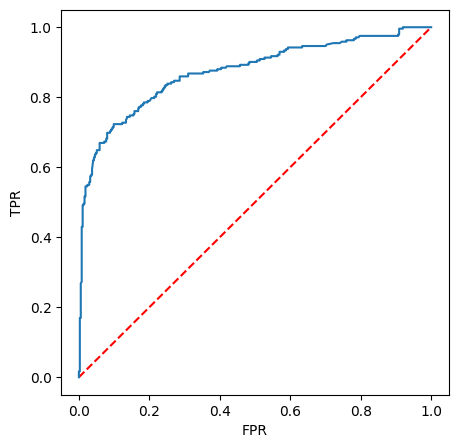

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

ML Pipeline 만들기

In [ ]:
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, MinMaxScaler

# Gender
stringIndexer = StringIndexer(inputCol = "Gender", outputCol = 'GenderIndexed')

# Age
imputer = Imputer(strategy='mean', inputCols=['Age'], outputCols=['AgeImputed'])

# Vectorize
inputCols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed']
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

# MinMaxScaler
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

stages = [stringIndexer, imputer, assembler, minmax_scaler]

In [ ]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
lr_stages = stages + [algo]

In [ ]:
lr_stages

[StringIndexer_b305e3d99bd7,
 Imputer_40714d028944,
 VectorAssembler_c4c91dbb4cda,
 MinMaxScaler_fb340f16cd5e,
 LogisticRegression_a9c83aef3a12]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = lr_stages)

In [ ]:
df = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])
df.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


In [ ]:
train, test = df.randomSplit([0.7, 0.3])

In [ ]:
lr_model = pipeline.fit(train)
lr_cv_predictions = lr_model.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8751727037904727

ML Tuning

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(algo.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)


In [ ]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8738511443503335

In [ ]:
lr_cv_predictions.select("prediction", "survived").show()

+----------+--------+
|prediction|survived|
+----------+--------+
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
+----------+--------+
only showing top 20 rows



In [ ]:
import pandas as pd

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cvModel.avgMetrics)
])

,areaUnderROC,maxIter
0,0.830599,1
1,0.849558,5
2,0.849418,10


GBT Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features_scaled", labelCol="Survived")
gbt_stages = stages + [gbt]

In [ ]:
gbt_stages

[StringIndexer_b305e3d99bd7,
 Imputer_40714d028944,
 VectorAssembler_c4c91dbb4cda,
 MinMaxScaler_fb340f16cd5e,
 GBTClassifier_59fcb73c47b6]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = gbt_stages)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [ ]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.869856430588094